In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, concatenate, Flatten ,Conv2D,MaxPool2D,BatchNormalization,Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import os
import cv2

In [2]:
# Load your data
df = pd.read_csv('modified_data.csv')


In [3]:
custom = Sequential()
custom.add(Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)))
custom.add(MaxPool2D(2,2))
custom.add(BatchNormalization())

custom.add(Conv2D(64,(3,3),activation='relu'))
custom.add(MaxPool2D(2,2))
custom.add(BatchNormalization())

custom.add(Conv2D(128,(3,3),activation='relu'))
custom.add(MaxPool2D(2,2))
custom.add(BatchNormalization())

custom.add(Flatten())
custom.add(Dense(128, activation='relu'))
custom.add(Dropout(0.2))

custom.add(Dense(64, activation='relu'))
custom.add(Dense(32, activation='relu'))
custom.add(Dense(1, activation='linear'))

In [4]:
custom.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                        

In [5]:
image_size = (224, 224)

image_features = []

for image_path in df['Image_Path']:
    img = load_img(image_path, target_size=image_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize the image data
    image_feature = custom.predict(img)  # Use your custom CNN model here
    image_features.append(image_feature)

image_features = np.vstack(image_features)


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 116ms/step


In [6]:
# Calculate the maximum value row-wise from the image features
max_image_features = np.max(image_features, axis=1)

# Create a new DataFrame with only the 'Image_FeatureCombined' column
combined_df = df.copy()
combined_df['Image_FeatureCombined'] = max_image_features

# Update the features list to include only 'Image_FeatureCombined'
features = ['Temperature', 'Humidity', 'Precipitation', 'Soil_Quality', 'Image_FeatureCombined']

# Extract the features from the combined_df
X_numerical_scaled = combined_df[features].values
# Drop all other image feature columns
combined_df.drop(columns=["Image_Feature_{}".format(i) for i in range(X_numerical_scaled.shape[1] - len(features))], inplace=True)

# Continue with the rest of your code
y = combined_df['SeverityIndex'].values

In [24]:
print("Image_FeatureCombined shape:", combined_df['Image_FeatureCombined'])

Image_FeatureCombined shape: 0      0.034405
1      0.024929
2      0.024089
3      0.018367
4      0.037382
         ...   
595    0.026038
596    0.027450
597    0.027641
598    0.031078
599    0.028760
Name: Image_FeatureCombined, Length: 600, dtype: float32


In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_numerical_scaled, y, test_size=0.2, stratify=df['Severity_Label'], random_state=42)

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [9]:
from tensorflow.keras.layers import LSTM, Input, Dense
def create_model(units=32):
    model = Sequential()
    model.add(LSTM(units, return_sequences=False, input_shape=(1, X_train.shape[2])))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model
    

In [10]:
# Create a KerasRegressor
model = KerasRegressor(build_fn=create_model, epochs=10, batch_size=32, verbose=1)

# Define hyperparameters to tune
param_grid = {'units': [32, 64, 128]}  # Example values for LSTM units

# Perform GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3)
grid_result = grid.fit(X_train, y_train)

# Print the best parameters and results
print(f'Best Parameters: {grid_result.best_params_}')
print(f'Best Mean absolute Error: {-grid_result.best_score_}')

# Use the best model for prediction
best_model = grid_result.best_estimator_.model


C:\Users\TOSHIBA\AppData\Local\Temp\ipykernel_10264\4194093710.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, epochs=10, batch_size=32, verbose=1)


Epoch 1/10
10/10 [==============================] - 5s 12ms/step - loss: 0.3917
Epoch 2/10
10/10 [==============================] - 0s 7ms/step - loss: 0.2608
Epoch 3/10
10/10 [==============================] - 0s 5ms/step - loss: 0.2164
Epoch 4/10
10/10 [==============================] - 0s 6ms/step - loss: 0.1705
Epoch 5/10
10/10 [==============================] - 0s 5ms/step - loss: 0.1293
Epoch 6/10
10/10 [==============================] - 0s 6ms/step - loss: 0.1059
Epoch 7/10
10/10 [==============================] - 0s 5ms/step - loss: 0.0965
Epoch 8/10
10/10 [==============================] - 0s 5ms/step - loss: 0.0937
Epoch 9/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0927
Epoch 10/10
5/5 [==============================] - 2s 4ms/step
Epoch 1/10
10/10 [==============================] - 4s 5ms/step - loss: 0.5423
Epoch 2/10
10/10 [==============================] - 0s 6ms/step - loss: 0.1651
Epoch 3/10
10/10 [==============================] - 0s 7ms/step - l

15/15 [==============================] - 0s 4ms/step - loss: 0.0884
Epoch 9/10
15/15 [==============================] - 0s 5ms/step - loss: 0.0865
Epoch 10/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0863
Best Parameters: {'units': 64}
Best Mean absolute Error: 0.0857173438546403


In [11]:
best_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 64)                17920     
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 17,985
Trainable params: 17,985
Non-trainable params: 0
_________________________________________________________________


In [12]:
y_pred = best_model.predict(X_test)
y_test = y_test.flatten()
y_pred = y_pred.flatten()

# Calculate Mean Squared Error (MSE) and R-squared (R2)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2) Score: {r2}')
print(f'Mean Absolute Error: {mae}')


4/4 [==============================] - 1s 4ms/step
Mean Squared Error (MSE): 0.012140855679905893
R-squared (R2) Score: 0.8850584310278254
Mean Absolute Error: 0.08547351539631684


In [13]:
import pandas as pd

# Create a DataFrame for actual and predicted values
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Display the DataFrame
print(comparison_df)


     Actual  Predicted
0      0.66   0.500982
1      0.16   0.331744
2      0.88   0.828505
3      0.93   0.926782
4      0.84   0.845918
..      ...        ...
115    0.41   0.367983
116    0.02   0.168891
117    0.02   0.101392
118    0.93   1.012537
119    0.43   0.393936

[120 rows x 2 columns]


In [14]:
# Check the column names after dropping unwanted columns
print(combined_df.columns)


Index(['Index', 'Date', 'Image_Path', 'Severity_Label', 'Temperature',
       'Humidity', 'Precipitation', 'Soil_Quality', 'SeverityIndex',
       'Image_FeatureCombined'],
      dtype='object')


In [15]:
combined_df.head()

,Index,Date,Image_Path,Severity_Label,Temperature,Humidity,Precipitation,Soil_Quality,SeverityIndex,Image_FeatureCombined
0,1,01-01-2023,ezyZip\Dataset\YELLOW-RUST-19\YELLOW-RUST-19\h...,healthy,24.18,62.62,0.61,6.67,0.03,0.034405
1,2,02-01-2023,ezyZip\Dataset\YELLOW-RUST-19\YELLOW-RUST-19\h...,healthy,24.06,59.87,0.62,6.53,0.06,0.024929
2,3,03-01-2023,ezyZip\Dataset\YELLOW-RUST-19\YELLOW-RUST-19\R...,healthy,22.88,64.58,0.63,5.84,0.04,0.024089
3,4,04-01-2023,ezyZip\Dataset\YELLOW-RUST-19\YELLOW-RUST-19\R...,healthy,22.09,53.03,0.65,5.99,0.09,0.018367
4,5,05-01-2023,ezyZip\Dataset\YELLOW-RUST-19\YELLOW-RUST-19\S...,healthy,22.93,59.39,0.64,6.76,0.09,0.037382


# GRAPHS


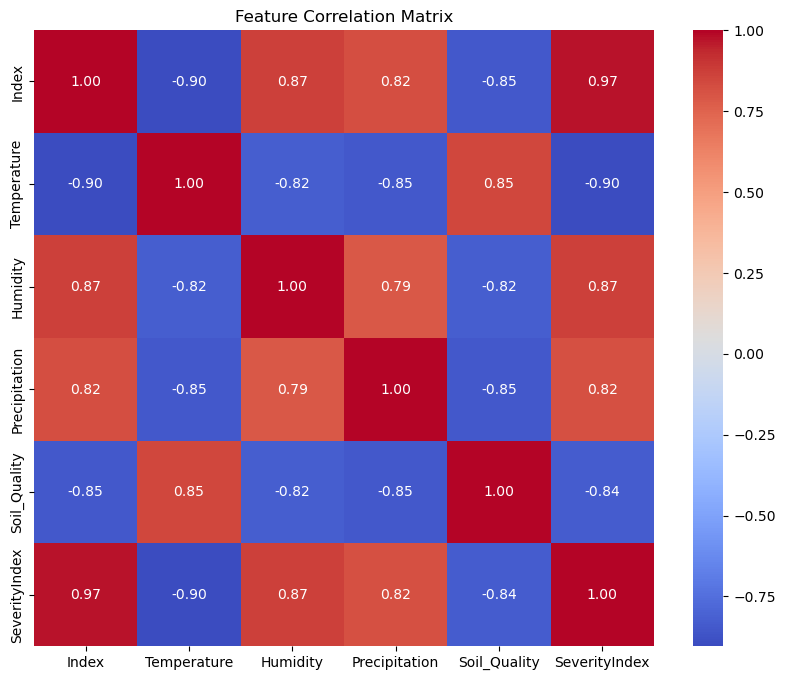

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming combined_df contains your data
numeric_columns = combined_df.select_dtypes(include=['number'])
numeric_columns = numeric_columns.drop(columns="Image_FeatureCombined")# Select only numeric columns
correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()


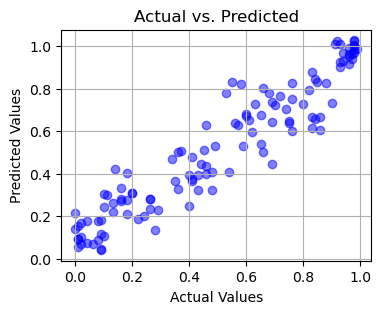

In [17]:
y_test = y_test.flatten()
y_pred = y_pred.flatten()

# Create an "Actual vs. Predicted" graph
plt.figure(figsize=(4, 3))
plt.scatter(y_test, y_pred, c='blue', alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Histogram of Residuals')

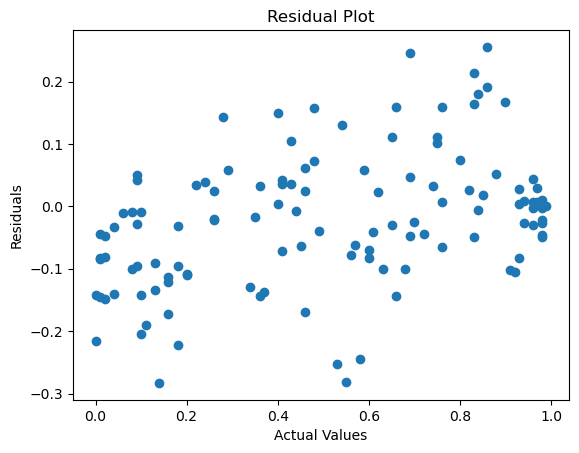

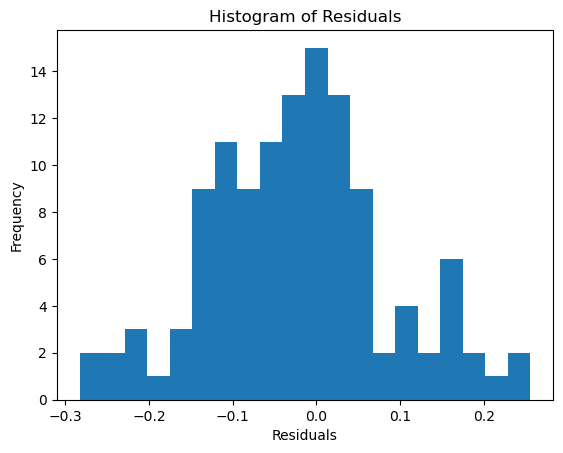

In [18]:
residuals = y_test - y_pred

# Plot residuals vs. actual values
plt.figure()
plt.scatter(y_test, residuals)
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")

# Plot a histogram of residuals
plt.figure()
plt.hist(residuals, bins=20)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")


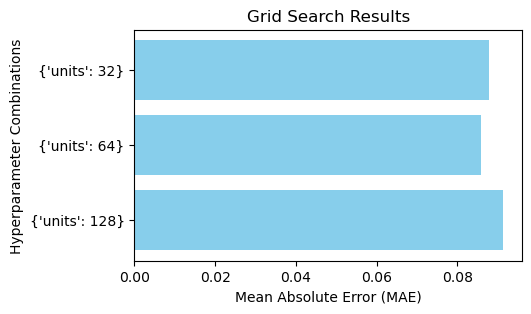

In [19]:
import matplotlib.pyplot as plt

# Access the grid search results
results = grid_result.cv_results_

# Extract the hyperparameter values and corresponding scores
param_values = [str(params) for params in results['params']]
mean_test_scores = -results['mean_test_score']

# Create a bar chart to visualize the results
plt.figure(figsize=(5, 3))
plt.barh(param_values, mean_test_scores, color='skyblue')
plt.xlabel('Mean Absolute Error (MAE)')
plt.ylabel('Hyperparameter Combinations')
plt.title('Grid Search Results')
plt.gca().invert_yaxis()  # Reverse the order for better visualization
plt.show()


In [20]:
import matplotlib.pyplot as plt

# Create a KerasRegressor with the best hyperparameters
best_units = grid_result.best_params_['units']
best_model = create_model(units=best_units)

# Train the model with a fixed number of epochs and batch size
history = best_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/100
15/15 [==============================] - 3s 66ms/step - loss: 0.1460 - val_loss: 0.1043
Epoch 2/100
15/15 [==============================] - 0s 8ms/step - loss: 0.1096 - val_loss: 0.0997
Epoch 3/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0975 - val_loss: 0.0953
Epoch 4/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0960 - val_loss: 0.0924
Epoch 5/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0927 - val_loss: 0.0894
Epoch 6/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0907 - val_loss: 0.0957
Epoch 7/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0936 - val_loss: 0.0911
Epoch 8/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0909 - val_loss: 0.0921
Epoch 9/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0881 - val_loss: 0.0859
Epoch 10/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0868 - val_loss: 0.0856
Epoch 11

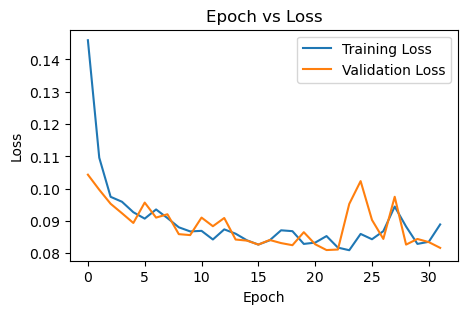

In [21]:
# Plot the epoch vs loss graph
plt.figure(figsize=(5, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.show()

In [22]:
!pip install pydot

In [26]:
from platform import python_version
print(python_version())

3.9.12
